In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
y1_inds = Variable(torch.zeros(11).long())
y2_inds = Variable(torch.ones(11).long())
train_y1 = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_y2 = Variable(torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [4]:
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch import ObservationModel
from gpytorch.random_variables import GaussianRandomVariable
from gpytorch.parameters import MLEParameterGroup
from torch.nn import Parameter

In [5]:
class MultitaskGPModel(gpytorch.ObservationModel):
    def __init__(self):
        super(MultitaskGPModel,self).__init__(GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()
        self.task_covar_module = IndexKernel()
        self.model_params = MLEParameterGroup(
            constant_mean=Parameter(torch.randn(1)),
            log_noise=Parameter(torch.randn(1)),
            log_lengthscale=Parameter(torch.randn(1)),
        )
        self.task_params = MLEParameterGroup(
            task_matrix=Parameter(torch.randn(2,1)),
            task_log_vars=Parameter(torch.randn(2)),
        )
    
    def forward(self,x,i):
        mean_x = self.mean_module(x, constant=self.model_params.constant_mean)
        
        covar_x = self.covar_module(x, log_lengthscale=self.model_params.log_lengthscale)
        covar_i = self.task_covar_module(i, 
                                         index_covar_factor=self.task_params.task_matrix,
                                         index_log_var=self.task_params.task_log_vars)
        
        covar_xi = covar_x.mul(covar_i)
        
        latent_pred = GaussianRandomVariable(mean_x, covar_xi)
        return latent_pred, self.model_params.log_noise

prior_observation_model = MultitaskGPModel()

In [6]:
def plot_model_and_predictions(observation_model):
    f, (y1_ax,y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    y1_inds_test = Variable(torch.zeros(51).long())
    y2_inds_test = Variable(torch.ones(51).long())
    
    observed_pred_y1 = observation_model(test_x,y1_inds_test)
    observed_pred_y2 = observation_model(test_x,y2_inds_test)

    def ax_plot(ax, train_y, rand_var, title):
        lower, upper = rand_var.confidence_region()
        ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(y1_ax, train_y1, observed_pred_y1, 'Observed Values (Likelihood)')
    ax_plot(y2_ax, train_y2, observed_pred_y2, 'Observed Values (Likelihood)')
    
    return f

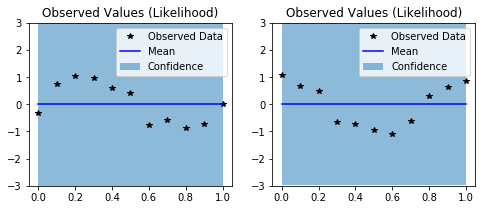

In [7]:
f = plot_model_and_predictions(prior_observation_model)

In [8]:
from gpytorch.inference import Inference

def log_function(loss, optimizer, observation_model):
    return 'Iter: %02d, Loss: %.3f' % (optimizer.n_iter, loss.data[0])

infer = Inference(prior_observation_model)
posterior_observation_model = infer.run((torch.cat([train_x,train_x]),
                                         torch.cat([y1_inds,y2_inds])),
                                        torch.cat([train_y1,train_y2]))

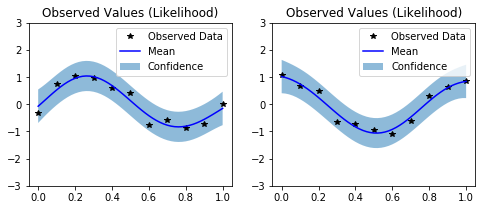

In [9]:
f = plot_model_and_predictions(posterior_observation_model)